# T5: Sentiment Analysis

Sentiment analysis, also called **opinion mining**, is the field of study that analyzes people’s opinions, sentiments, evaluations, appraisals, attitudes, and emotions towards entities such as products, services, organizations, individuals, issues, events, topics, and their attributes. It represents a large problem space. There are also many names and slightly different tasks, e.g., sentiment analysis, opinion mining, opinion extraction, sentiment mining, subjectivity analysis, affect analysis, emotion analysis, review mining, etc. However, they are now all under the umbrella of sentiment analysis or opinion mining. 

Although linguistics and natural language processing (NLP) have a long history, little research had been done about people’s opinions and sentiments before the year 2000. Since then, the field has become a very active research area.


## Vocabulary

* *stop words*: 
    * The most common words in a language.
* *tokenization*:
    * Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation. 
* *token*:
    *  A token is an instance of a sequence of characters in some particular document that are grouped together as a useful semantic unit for processing.
* *type*:
    * A type is the class of all tokens containing the same character sequence.
* *Document Term Matrix (DTM)*:
    * a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In a DTM, rows correspond to documents in the collection and columns correspond to terms. Making a DTM is a common preprocessing step: it takes in tokenized texts and makes them ready for downstream tasks (e.g., topic models, supervised machine learning models).

---

Libraries: 

In [1]:
from tqdm.notebook import tqdm
from transformers import pipeline
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.sentiment import SentimentIntensityAnalyzer
from torch.utils.data import Dataset
from tabulate import tabulate
from elasticsearch import Elasticsearch, helpers
from scipy.special import softmax

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns

import torch
import torch as torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

import math
import itertools

In [2]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [3]:
res = classifier("I was sick last week.")

In [4]:
print(res)

[{'label': 'NEGATIVE', 'score': 0.9995399713516235}]


In [5]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

In [6]:
classifier = pipeline("sentiment-analysis", model=model_name)

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [10]:
results = classifier(["I hate you", "I love you", "I am bored"])

In [11]:
print(results)

[{'label': 'NEGATIVE', 'score': 0.9991129040718079}, {'label': 'POSITIVE', 'score': 0.9998656511306763}, {'label': 'NEGATIVE', 'score': 0.9998152852058411}]


In [12]:
tokens = tokenizer.tokenize("I hate you")
token_ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = tokenizer("I hate you")

In [13]:
print(f"Tokens:{tokens}")
print(f"Token IDs: {token_ids}")
print(f"Input IDs: {input_ids}")

Tokens:['i', 'hate', 'you']
Token IDs: [1045, 5223, 2017]
Input IDs: {'input_ids': [101, 1045, 5223, 2017, 102], 'attention_mask': [1, 1, 1, 1, 1]}


In [14]:
X_train = ["I hate you", "I love you"]

In [15]:
batch = tokenizer(
    X_train, padding=True, truncation=True, max_length=512, return_tensors="pt"
)

In [16]:
print(batch)

{'input_ids': tensor([[ 101, 1045, 5223, 2017,  102],
        [ 101, 1045, 2293, 2017,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])}


In [17]:
with torch.no_grad():  # * Disables gradient calculations to save memory and compute, no backpropagation
    outputs = model(
        **batch
    )  # ? - Preprocessed data is fed into de model, ** is used ot unpack the dictionary into the models input arguments.

    # ? - SequenceClassifier Output which includes logits [# of examples, # of classes] We have two scores per instance corresponding to negative or positive.
    # ? - Raw prediction of each class.
    print(f"Model output:\n{outputs}")

    # ? - We apply a softmax to convert the logits to probabilities.
    # ? -Dim = 1, specifies that we should apply them across the columns, normalising the logits into probabilities.
    predictions = F.softmax(outputs.logits, dim=1)
    print(f"\nPrediction output:\n{predictions}")

    # ? - Pick the index of the highest value in each row of predictions, which will give us the most likely class for a label
    labels = torch.argmax(predictions, dim=1)
    print(f"\nLabels:\n{labels}")

    # ? - Finds the corresponding model label to the readable value
    labels = [model.config.id2label[label_id] for label_id in labels.tolist()]
    print(labels)

Model output:
SequenceClassifierOutput(loss=None, logits=tensor([[ 3.8724, -3.1543],
        [-4.2756,  4.6393]]), hidden_states=None, attentions=None)

Prediction output:
tensor([[9.9911e-01, 8.8707e-04],
        [1.3436e-04, 9.9987e-01]])

Labels:
tensor([0, 1])
['NEGATIVE', 'POSITIVE']


# Example 1 (Read in Data and NLTK Basics)

In this example we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗 Huggingface Pipeline

In [18]:
# Read in data
df = pd.read_csv("reviews10k.csv")
print(df.shape)
df = df.head(15000)
print(df.shape)

(10000, 10)
(10000, 10)


In [19]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


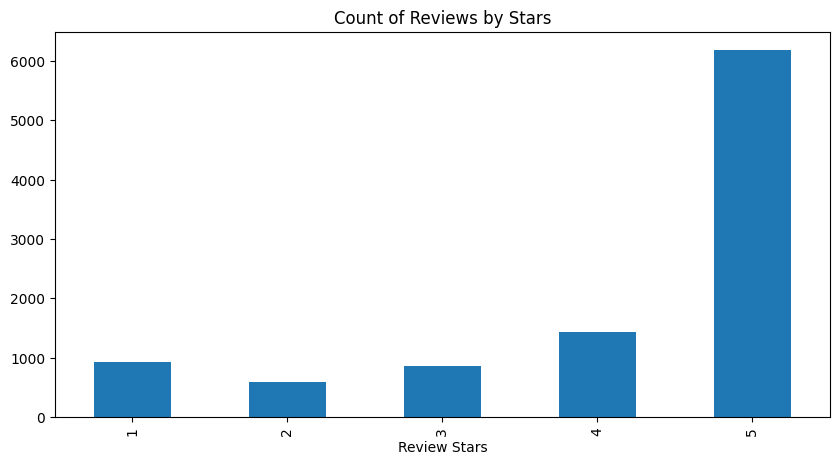

In [20]:
ax = (
    df["Score"]
    .value_counts()
    .sort_index()
    .plot(kind="bar", title="Count of Reviews by Stars", figsize=(10, 5))
)
ax.set_xlabel("Review Stars")
plt.show()

In [21]:
example = df["Text"][42]
print(example)

I have McCann's Oatmeal every morning and by ordering it from Amazon I am able to save almost $3.00 per box.<br />It is a great product. Tastes great and very healthy


In [22]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['I',
 'have',
 'McCann',
 "'s",
 'Oatmeal',
 'every',
 'morning',
 'and',
 'by',
 'ordering']

In [23]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('I', 'PRP'),
 ('have', 'VBP'),
 ('McCann', 'NNP'),
 ("'s", 'POS'),
 ('Oatmeal', 'NNP'),
 ('every', 'DT'),
 ('morning', 'NN'),
 ('and', 'CC'),
 ('by', 'IN'),
 ('ordering', 'VBG')]

This function is used to tag parts of speech (POS) in a given text. It takes a list of words as input and returns a list of tuples, where each tuple contains a word from the input along with its corresponding part of speech tag.

In [24]:
nltk.download("maxent_ne_chunker")
nltk.download("words")
nltk.download("vader_lexicon")

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/ytobio/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/ytobio/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ytobio/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [25]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  have/VBP
  (PERSON McCann/NNP)
  's/POS
  Oatmeal/NNP
  every/DT
  morning/NN
  and/CC
  by/IN
  ordering/VBG
  it/PRP
  from/IN
  (GPE Amazon/NNP)
  I/PRP
  am/VBP
  able/JJ
  to/TO
  save/VB
  almost/RB
  $/$
  3.00/CD
  per/IN
  box./NN
  </NN
  br/NN
  //NNP
  >/NN
  It/PRP
  is/VBZ
  a/DT
  great/JJ
  product/NN
  ./.
  Tastes/VBZ
  great/JJ
  and/CC
  very/RB
  healthy/JJ)


The `ne_chunk()` function takes a list of tagged tokens (usually part-of-speech tagged) as input and returns a nested tree structure where named entities are recognized and labeled. Each entity is represented as a subtree in the output, with the entity label as the node's label.

# VADER Sentiment Scoring

In NLTK (Natural Language Toolkit), "Vader" refers to the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool. VADER is specifically designed to analyze the sentiment of text, especially social media texts, by providing a score representing the positivity, negativity, and neutrality of the text. 

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [26]:
sia = SentimentIntensityAnalyzer()

In [27]:
sia.polarity_scores("I am so happy!")

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In VADER sentiment analysis, the "compound" score represents the overall sentiment of a piece of text. It's a single value that combines the scores of the individual words in the text to provide an overall sentiment score.

The compound score ranges from -1 to 1.

In [28]:
sia.polarity_scores("This is the worst thing ever.")

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [29]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.9441}

In [30]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["Text"]
    myid = row["Id"]
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [31]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index": "Id"})
vaders = vaders.merge(df, how="left")

In [32]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


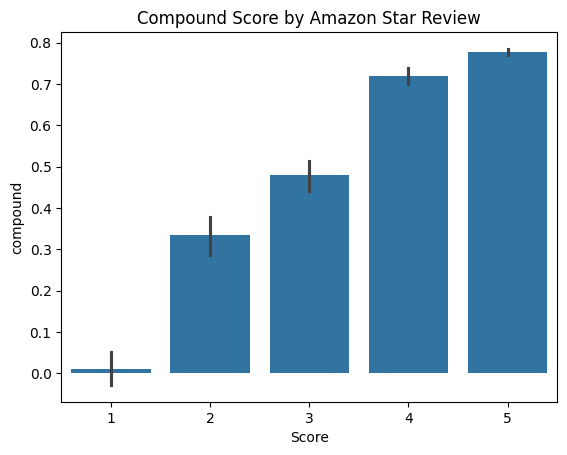

In [33]:
ax = sns.barplot(data=vaders, x="Score", y="compound")
ax.set_title("Compound Score by Amazon Star Review")
plt.show()

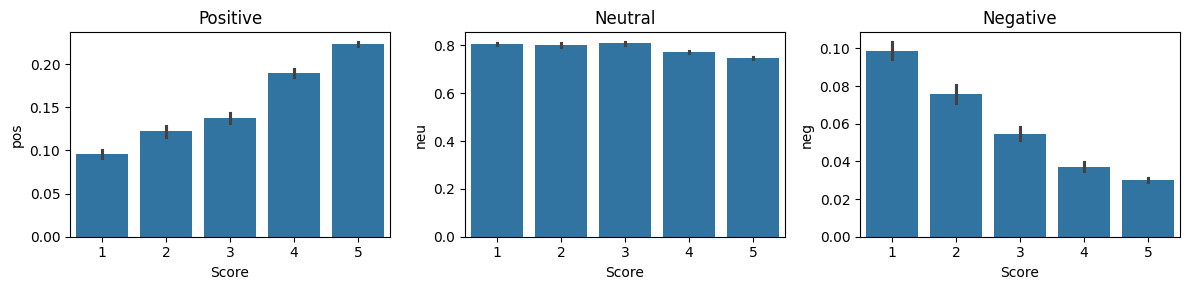

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x="Score", y="pos", ax=axs[0])
sns.barplot(data=vaders, x="Score", y="neu", ax=axs[1])
sns.barplot(data=vaders, x="Score", y="neg", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()

---

Recommender - MF

In [35]:
vaders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      10000 non-null  int64  
 1   neg                     10000 non-null  float64
 2   neu                     10000 non-null  float64
 3   pos                     10000 non-null  float64
 4   compound                10000 non-null  float64
 5   ProductId               10000 non-null  object 
 6   UserId                  10000 non-null  object 
 7   ProfileName             10000 non-null  object 
 8   HelpfulnessNumerator    10000 non-null  int64  
 9   HelpfulnessDenominator  10000 non-null  int64  
 10  Score                   10000 non-null  int64  
 11  Time                    10000 non-null  int64  
 12  Summary                 10000 non-null  object 
 13  Text                    10000 non-null  object 
dtypes: float64(4), int64(5), object(5)
memo

In [36]:
data1 = vaders.drop(["Id", "Summary", "Text", "ProfileName"], axis=1)

In [37]:
data1.columns

Index(['neg', 'neu', 'pos', 'compound', 'ProductId', 'UserId',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time'],
      dtype='object')

In [38]:
data1.head()

,neg,neu,pos,compound,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
0,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400
1,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000
2,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600
3,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200
4,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600


In [39]:
data1["userId"] = [hash(uid) for uid in data1["UserId"].values]

In [40]:
data1["productId"] = [hash(uid) for uid in data1["ProductId"].values]

In [41]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neg                     10000 non-null  float64
 1   neu                     10000 non-null  float64
 2   pos                     10000 non-null  float64
 3   compound                10000 non-null  float64
 4   ProductId               10000 non-null  object 
 5   UserId                  10000 non-null  object 
 6   HelpfulnessNumerator    10000 non-null  int64  
 7   HelpfulnessDenominator  10000 non-null  int64  
 8   Score                   10000 non-null  int64  
 9   Time                    10000 non-null  int64  
 10  userId                  10000 non-null  int64  
 11  productId               10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [42]:
data2 = data1.drop(["ProductId", "UserId"], axis=1)

In [43]:
data2.head()

,neg,neu,pos,compound,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,userId,productId
0,0.000,0.695,0.305,0.9441,1,1,5,1303862400,-1458152287295995432,-720376580139923522
1,0.138,0.862,0.000,-0.5664,0,0,1,1346976000,-7115036019224333918,-2491189373829460775
2,0.091,0.754,0.155,0.8265,1,1,4,1219017600,9140919092185969819,4292312397202778566
3,0.000,1.000,0.000,0.0000,3,3,2,1307923200,395522562175020203,7391172793852939005
4,0.000,0.552,0.448,0.9468,0,0,5,1350777600,-4901925811461802529,-4666513168371199006


In [44]:
data2.columns

Index(['neg', 'neu', 'pos', 'compound', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'userId', 'productId'],
      dtype='object')

In [45]:
feature_columns = [
    "neg",
    "neu",
    "pos",
    "compound",
    "HelpfulnessNumerator",
    "HelpfulnessDenominator",
    "Time",
    "userId",
    "productId",
]

In [46]:
features_sizes = {
    "userId": data1["userId"].nunique(),
    "productId": data1["productId"].nunique(),
    "HelpfulnessNumerator": data1["HelpfulnessNumerator"].nunique(),
    "HelpfulnessDenominator": data1["HelpfulnessDenominator"].nunique(),
    "Time": data1["Time"].nunique(),
    "neg": data1["neg"].nunique(),
    "neu": data1["neu"].nunique(),
    "pos": data1["pos"].nunique(),
    "compound": data1["compound"].nunique(),
}

We are interested in calculating the offsets for encoding techniques. 
This is where features are represented as vectors in a larger matrix or array.
The offsets tells us where the encoding for each feature starts. 

So what this is essentially doing is filling in a dictionary with an indicator of how many positions it must cross to get to the next feature. This is useful to determine the dimension space for each feature. 

In [47]:
# * Calculate offsets.
# * Each feature starts from the end of the last one.
next_offset = 0
features_offsets = {}
for k, v in features_sizes.items():
    features_offsets[k] = next_offset
    next_offset += v

In [48]:
features_offsets

{'userId': 0,
 'productId': 9015,
 'HelpfulnessNumerator': 10437,
 'HelpfulnessDenominator': 10495,
 'Time': 10559,
 'neg': 12511,
 'neu': 12794,
 'pos': 13318,
 'compound': 13838}

In [49]:
# * map all column indices to start from correct offset
# * We take every value in a column, and we add the corresponding offset to that column.
for column in feature_columns:
    data2[column] = data2[column].apply(lambda c: c + features_offsets[column])

In [50]:
data2[[*feature_columns, "Score"]].head(
    5
)  # * This is a way to just display the columns we're interested in, and we unpack the feature columns

,neg,neu,pos,compound,HelpfulnessNumerator,HelpfulnessDenominator,Time,userId,productId,Score
0,12511.000,12794.695,13318.305,13838.9441,10438,10496,1303872959,-1458152287295995432,-720376580139914507,5
1,12511.138,12794.862,13318.000,13837.4336,10437,10495,1346986559,-7115036019224333918,-2491189373829451760,1
2,12511.091,12794.754,13318.155,13838.8265,10438,10496,1219028159,9140919092185969819,4292312397202787581,4
3,12511.000,12795.000,13318.000,13838.0000,10440,10498,1307933759,395522562175020203,7391172793852948020,2
4,12511.000,12794.552,13318.448,13838.9468,10437,10495,1350788159,-4901925811461802529,-4666513168371189991,5


# Roberta Pretrained Model from Hugging Face

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [51]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [52]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [53]:
tokens = tokenizer.tokenize("I hate you")
token_ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = tokenizer("I hate you")
print(f"Tokens:{tokens}")
print(f"Token IDs: {token_ids}")
print(f"Input IDs: {input_ids}")

Tokens:['I', 'Ġhate', 'Ġyou']
Token IDs: [100, 4157, 47]
Input IDs: {'input_ids': [0, 100, 4157, 47, 2], 'attention_mask': [1, 1, 1, 1, 1]}


In [54]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors="pt")
print(f"Example text: {example}\nEncoded Text Output:{encoded_text}\n")

# * We can observe from the output the negative, neutral and positive logits
output = model(**encoded_text)
print(f"\nOutput:\n{output}")

# ? - Get the scores as logits and place it in a numpy vector
scores = output[0][0].detach().numpy()
# * Apply softmax to pass it to a probability and assign
scores = softmax(scores)
scores_dict = {
    "roberta_neg": scores[0],
    "roberta_neu": scores[1],
    "roberta_pos": scores[2],
}
print(f"\nScores Dictionary final: {scores_dict}")

Example text: I have McCann's Oatmeal every morning and by ordering it from Amazon I am able to save almost $3.00 per box.<br />It is a great product. Tastes great and very healthy
Encoded Text Output:{'input_ids': tensor([[    0,   100,    33, 22358,    18,   384, 38615,   358,   662,     8,
            30, 12926,    24,    31,  1645,    38,   524,   441,     7,  1871,
           818,    68,   246,     4,   612,   228,  2233, 49069,  3809, 48709,
           243,    16,    10,   372,  1152,     4,   255,  1988,   293,   372,
             8,   182,  2245,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


Output:
SequenceClassifierOutput(loss=None, logits=tensor([[-2.5822, -0.6898,  3.9755]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Scores Dictionary final: {'roberta_neg': 0.0014039391, 'roberta_neu': 0.009315226, 'roberta_pos': 0.98

In [55]:
df = pd.read_csv("reviews10k.csv")
df = df.head(3000)
df.shape

(3000, 10)

In [56]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**Recommender Model**

In [57]:
reviews_per_rating = df[["ProductId"]].value_counts()

# !! - Group by Product, and select those which have more than 10 reviews like in the exam
select_product = (reviews_per_rating >= 10).groupby("ProductId").all()
select_product = select_product.index[select_product].to_list()
df = df.loc[df["ProductId"].isin(select_product)]
df.shape

(1870, 10)

In [58]:
df.value_counts("Score", normalize=True)

Score
5    0.613904
4    0.147594
1    0.089840
3    0.085561
2    0.063102
Name: proportion, dtype: float64

In [59]:
# Numer of unique users and products
n_users = df["UserId"].nunique()
print("UNIQUE USERS: ", n_users)
n_products = df["ProductId"].nunique()
print("UNIQUE PRODUCTS: ", n_products)

UNIQUE USERS:  1806
UNIQUE PRODUCTS:  59


In [60]:
def print_sparsity(df):
    n_users = df.UserId.nunique()
    n_items = df.ProductId.nunique()
    n_ratings = len(df)
    rating_matrix_size = n_users * n_items
    sparsity = 1 - n_ratings / rating_matrix_size

    print(f"Number of users: {n_users}")
    print(f"Number of items: {n_items}")
    print(f"Number of available ratings: {n_ratings}")
    print(f"Number of all possible ratings: {rating_matrix_size}")
    print("-" * 40)
    print(f"SPARSITY: {sparsity * 100.0:.2f}%")


print_sparsity(df)

Number of users: 1806
Number of items: 59
Number of available ratings: 1870
Number of all possible ratings: 106554
----------------------------------------
SPARSITY: 98.25%



::: {.callout-tip icon="false}
### Convert text to numbers - NLTK

Use the summary or/and description to generate numerical columns.

:::

In [61]:
df["Text"]

13      good flavor! these came securely packed... the...
14      The Strawberry Twizzlers are my guilty pleasur...
15      My daughter loves twizzlers and this shipment ...
16      I love eating them and they are good for watch...
17      I am very satisfied with my Twizzler purchase....
                              ...                        
2979    I think Namaste Gluten Free Spice Cake Mix is ...
2980    I've made these twice in cupcake form, topped ...
2981    I used this mix to make a 9x13 cake in a glass...
2982    This mix allowed my little one to have cupcake...
2983    The chocolate cake is fantastic, so I had reas...
Name: Text, Length: 1870, dtype: object

In [62]:
df["Summary"]

13                                fresh and greasy!
14                     Strawberry Twizzlers - Yummy
15         Lots of twizzlers, just what you expect.
16                                       poor taste
17                                         Love it!
                           ...                     
2979    Namaste Foods, Gluten Free Vanilla cake Mix
2980                              yummy as cupcakes
2981                                          Tasty
2982                          2nd Birthday Saviour!
2983                                     Just awful
Name: Summary, Length: 1870, dtype: object

**Vader - Summary Col**

In [63]:
# * Run the polarity score on the summary column of the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["Summary"]
    myid = row["Id"]
    res[myid] = sia.polarity_scores(str(text))

  0%|          | 0/1870 [00:00<?, ?it/s]

In [64]:
vaders_preview = pd.DataFrame(res)
vaders_preview.head()

,14,15,16,17,18,19,20,21,22,23,...,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984
neg,0.0000,0.0000,0.0,0.7560,0.0000,0.0000,0.0,0.0000,0.0,0.0000,...,0.0000,0.0000,0.6430,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.7500
neu,0.4360,0.3700,1.0,0.2440,0.1820,0.1190,1.0,0.3030,1.0,0.2000,...,0.4760,0.5080,0.3570,0.4230,1.0,0.6450,0.3700,1.0,1.0,0.2500
pos,0.5640,0.6300,0.0,0.0000,0.8180,0.8810,0.0,0.6970,0.0,0.8000,...,0.5240,0.4920,0.0000,0.5770,0.0,0.3550,0.6300,0.0,0.0,0.0000
compound,0.3802,0.5267,0.0,-0.4767,0.6696,0.8122,0.0,0.3182,0.0,0.6114,...,0.5106,0.4404,-0.2023,0.6249,0.0,0.5106,0.5267,0.0,0.0,-0.4588


In [65]:
vaders = pd.DataFrame(res).T  # * Transpose so we can merge it.
vaders = vaders.reset_index().rename(columns={"index": "Id"})
vaders = vaders.merge(df, how="left")

In [66]:
vaders.head(1)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,14,0.0,0.436,0.564,0.3802,B001GVISJM,A18ECVX2RJ7HUE,"willie ""roadie""",2,2,4,1288915200,fresh and greasy!,good flavor! these came securely packed... the...


**Roberta - Text col**

In [67]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors="pt")
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        "roberta_neg": scores[0],
        "roberta_neu": scores[1],
        "roberta_pos": scores[2],
    }
    return scores_dict

In [68]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row["Text"]
        myid = row["Id"]
        roberta_result = polarity_scores_roberta(str(text))
        res[myid] = {**roberta_result}
    except RuntimeError:
        print(f"Broke for id {myid}")

  0%|          | 0/1870 [00:00<?, ?it/s]

Broke for id 529
Broke for id 540
Broke for id 863
Broke for id 1321
Broke for id 1375
Broke for id 1575
Broke for id 1796
Broke for id 1826
Broke for id 2169
Broke for id 2476
Broke for id 2584
Broke for id 2610
Broke for id 2897
Broke for id 2898
Broke for id 2902
Broke for id 2928
Broke for id 2942
Broke for id 2944
Broke for id 2947
Broke for id 2948


In [69]:
ratings = pd.DataFrame(res).T
ratings = ratings.reset_index().rename(columns={"index": "Id"})
ratings = ratings.merge(vaders, how="left")

In [70]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      1850 non-null   int64  
 1   roberta_neg             1850 non-null   float32
 2   roberta_neu             1850 non-null   float32
 3   roberta_pos             1850 non-null   float32
 4   neg                     1850 non-null   float64
 5   neu                     1850 non-null   float64
 6   pos                     1850 non-null   float64
 7   compound                1850 non-null   float64
 8   ProductId               1850 non-null   object 
 9   UserId                  1850 non-null   object 
 10  ProfileName             1850 non-null   object 
 11  HelpfulnessNumerator    1850 non-null   int64  
 12  HelpfulnessDenominator  1850 non-null   int64  
 13  Score                   1850 non-null   int64  
 14  Time                    1850 non-null   

In [71]:
ratings.head()

,Id,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,14,0.001408,0.005883,0.992709,0.000,0.436,0.564,0.3802,B001GVISJM,A18ECVX2RJ7HUE,"willie ""roadie""",2,2,4,1288915200,fresh and greasy!,good flavor! these came securely packed... the...
1,15,0.001824,0.021841,0.976335,0.000,0.370,0.630,0.5267,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
2,16,0.004562,0.032325,0.963112,0.000,1.000,0.000,0.0000,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,1262044800,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...
3,17,0.002923,0.013420,0.983658,0.756,0.244,0.000,-0.4767,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...
4,18,0.001112,0.008006,0.990882,0.000,0.182,0.818,0.6696,B001GVISJM,AFKW14U97Z6QO,Becca,0,0,5,1345075200,Love it!,I am very satisfied with my Twizzler purchase....


---

## References

1.  Aggarwal, C. C. (2016). Recommender systems (Vol. 1). Cham: Springer International Publishing.
   
2.  Hugging Face. (n.d.). roberta-base. Retrieved from https://huggingface.co/roberta-base

3.  Hutto, C. J., & Gilbert, E. (2014). VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text. In Eighth International Conference on Weblogs and Social Media (ICWSM-14). Retrieved January 2015, from http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf


---